# Data Attribution Mislabeled Data Detection Experiments

In [1]:
import random
import time
import copy
from datetime import datetime

import numpy as np
import pandas as pd
from tqdm import tqdm

import torch
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader
import torch.nn.functional as F

from sklearn.model_selection import train_test_split
from transformers import DistilBertForSequenceClassification, AdamW, DistilBertTokenizer, DistilBertConfig
from trak import TRAKer

import seaborn as sns
from matplotlib import pyplot as plt


In [2]:
#Settings

#Data Settings

csv_path = './ecommerceDataset.csv'
mislabeled_frac = 0.4
mislabeled_class = "Electronics"
test_percent = 0.8
save_path = "./"
tokenizer_name = "./distilbert_tokenizer"

#Training Settings
device = "cuda"
epochs = 1
lr = 5e-05
eps = 1e-8
batch_size = 32

load_from_file = True
train_df_filepath = "12-02-2023-20:55_mislabel_train-df_Electronics_0.4.pkl"
test_df_filepath = "12-02-2023-20:55_mislabel_test-df_Electronics_0.4.pkl"

#TRAK Settings
load_model_path = f'model_lr{lr}_bs{batch_size}_mislabeled_{mislabeled_class}_{mislabeled_frac}.pt'
trak_save_folder = "temp_savedir"
val_sample_size = 500

In [3]:
# Initialize tokenizer, define function to parse our dataset into TensorDataset
def tokenizer_function(input_data, labels):
  input_ids = []
  attention_masks = []
  for sent in tqdm(input_data):
    this_encoding = tokenizer.encode_plus(sent, truncation=True, pad_to_max_length = True,max_length = 512,return_attention_mask = True,return_tensors = 'pt')
    input_ids.append(this_encoding['input_ids'])
    attention_masks.append( this_encoding['attention_mask'])

  input_ids = torch.cat(input_ids, dim=0)
  attention_masks = torch.cat(attention_masks, dim=0)
  labels = torch.tensor(labels)
  
  tokenized_data = TensorDataset(input_ids, attention_masks, labels)
  return tokenized_data

tokenizer = DistilBertTokenizer.from_pretrained(tokenizer_name)

## Dataset Generation

### Load and Split Data

In [ ]:
df = pd.read_csv(csv_path,names=['class','text'])
df['class_int'] = pd.factorize(df['class'])[0].astype(int)
df=df.dropna()

In [ ]:
df

In [ ]:
train_df, test_df = train_test_split(df, test_size=test_percent)
print(f"Training Size: {train_df.shape}, Test Size: {test_df.shape}")

### Training Data Mislabeling

In [ ]:
def label_swap(row, selected_row_list):
  if row.name in selected_row_list:
    #Get list of all other class ints
    other_class_ints = [x for x in range(len(df["class"].unique()))]
    other_class_ints.pop(row["class_int"])

    return random.choice(other_class_ints)
  else:
    return row["class_int"]
  
selected_indicies = train_df[train_df["class"] == mislabeled_class].sample(frac=mislabeled_frac).index
train_df["mislabeled_labels"] = train_df.apply(lambda x: label_swap(x, selected_indicies), axis=1)
print(f"Mislabeled {train_df[train_df['class_int'] != train_df['mislabeled_labels']].shape[0]} of {train_df[train_df['class'] == mislabeled_class].shape[0]} training examples from {mislabeled_class} class")

In [ ]:
date_str = datetime.now().strftime("%m-%d-%Y-%H:%M")

print("Saving...")
train_df.to_pickle(save_path + f"{date_str}_mislabel_train-df_{mislabeled_class}_{mislabeled_frac}.pkl")
test_df.to_pickle(save_path + f"{date_str}_mislabel_test-df_{mislabeled_class}_{mislabeled_frac}.pkl")
print("Done!")

## Model Training

### Load and Tokenize mislabeled data

In [ ]:
if load_from_file is True:
    train_df = pd.read_pickle(train_df_filepath)
    test_df = pd.read_pickle(test_df_filepath)

train_dataset = tokenizer_function(train_df.text.to_list(), train_df.mislabeled_labels.to_list())
val_dataset = tokenizer_function(test_df.text.to_list(), test_df.class_int.to_list())

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)

n_labels = len(train_df['class'].unique())

In [ ]:
#Helper Functions
def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    elapsed_rounded = int(round((elapsed)))

    return str(datetime.timedelta(seconds=elapsed_rounded))

def flat_accuracy(preds, labels):
    """
    Function to calculate the accuracy of our predictions vs labels
    """
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

### DistilBERT Training on Mislabeled Data

In [ ]:
def train_loop(model, train_loader, optimizer):
    model.train()

    total_train_accuracy=0
    total_train_loss = 0
    for step, batch in tqdm(enumerate(train_loader), total=len(train_loader)):
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        model.zero_grad()

        outputs = model(b_input_ids,
                                attention_mask=b_input_mask,
                                labels=b_labels)
        loss = outputs.loss
        total_train_loss += loss

        loss.backward()

        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        optimizer.step()
        if(step %300 == 0):
            print(loss)

        logits = outputs.logits

        # Move logits and labels to CPU
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()
        total_train_accuracy += flat_accuracy(logits, label_ids)

    avg_train_loss = total_train_loss / len(train_loader)
    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))

    return total_train_accuracy


def eval_loop(model, val_loader):
    # Tracking variables
    total_eval_accuracy = 0
    total_eval_loss = 0

    # Evaluate data for one epoch
    for batch in tqdm(val_loader, total=len(val_loader)):
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        with torch.no_grad():

            outputs = model(b_input_ids,
                                    attention_mask=b_input_mask,
                                    labels=b_labels)

        # Accumulate the validation loss.
        loss = outputs.loss
        logits = outputs.logits
        total_eval_loss += loss.item()

        # Move logits and labels to CPU
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()

        # Calculate the accuracy for this batch of test sentences, and
        # accumulate it over all batches.
        total_eval_accuracy += flat_accuracy(logits, label_ids)

    # Calculate the average loss over all of the batches.
    avg_val_loss = total_eval_loss / len(val_loader)
    print("Average Batch Validation Loss: {0:.2f}".format(avg_val_loss))

    return total_eval_accuracy

### Training Loop

In [ ]:
model = DistilBertForSequenceClassification.from_pretrained('./distilbert_model', num_labels=n_labels, output_attentions = False, output_hidden_states=False)
optimizer = AdamW(model.parameters(),
                lr = lr, # args.learning_rate - default is 5e-5.
                eps = eps
              )

model.to(device)

for epoch in range(epochs):
  print(f'\n Epoch {epoch}')
  total_train_acc = train_loop(model, train_loader, optimizer)

  print("\nRunning Validation...\n")
  total_eval_acc = eval_loop(model, val_loader)

  # Report the final accuracy for this validation run.
  avg_train_accuracy = total_train_acc / len(train_loader)
  avg_val_accuracy = total_eval_acc / len(val_loader)
  print("  Accuracy Val: {0:.2f}".format(avg_val_accuracy))
  print("  Accuracy Train: {0:.2f}".format(avg_train_accuracy))

print("\nTraining complete! Saving model...")

model_name = f'test_model_lr{lr}_bs{batch_size}_mislabeled_{mislabeled_class}_{mislabeled_frac}.pt'
torch.save(model.state_dict(), model_name)

print(f'model saved {model_name}')


## Generate Influence Scores

In [4]:
if load_from_file is True:
    train_df = pd.read_pickle(train_df_filepath)
    test_df = pd.read_pickle(test_df_filepath).head(val_sample_size)

train_dataset = tokenizer_function(train_df.text.to_list(), train_df.mislabeled_labels.to_list())
val_dataset = tokenizer_function(test_df.text.to_list(), test_df.class_int.to_list())

n_labels = len(train_df['class'].unique())

  0%|          | 0/10084 [00:00<?, ?it/s]/home/gridsan/sjorgensen/.local/lib/python3.9/site-packages/transformers/tokenization_utils_base.py:2614: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
100%|██████████| 500/500 [00:00<00:00, 592.98it/s]


In [5]:
# Helper Functions
def process_batch(batch):
    # return batch['input_ids'], batch['token_type_ids'], batch['attention_mask'], batch['labels']
    return batch[0], batch[1], batch[1], batch[2]


class TRAKDistilBertSequenceClassificationModel(torch.nn.Module):
    """
    Wrapper for HuggingFace sequence classification models.
    """
    def __init__(self):
        super().__init__()
        n_lab = n_labels

        self.config = DistilBertConfig.from_pretrained(
            './distilbert_model',
            num_labels=n_lab
        )

        self.model = DistilBertForSequenceClassification.from_pretrained(
            './distilbert_model',
            num_labels=n_lab,
            output_attentions = False,
            output_hidden_states=False
        )
        self.model.eval().to(device)

    def forward(self, input_ids, token_type_ids, attention_mask): # jyh (11/17): TRAK calls for a slight tweak in the forward function to fit API signatures: https://trak.readthedocs.io/en/latest/bert.html
        return self.model(input_ids=input_ids, attention_mask=attention_mask).logits


def init_model(ckpt_path, device):
    model = TRAKDistilBertSequenceClassificationModel()
    if type(ckpt_path) is str:
      sd = torch.load(ckpt_path, map_location=torch.device(device)) # jyh: (11/18) this worked for the baseline DistilBertSequenceClassificationModel.
    else:
      sd = ckpt_path.state_dict()
    model.model.load_state_dict(sd)

    return model


def make_traker(model_path,train_dataset, save_dir, proj_dim=512):
    TRAIN_SET_SIZE = len(train_dataset)

    print(f'train set size: {TRAIN_SET_SIZE}')
    loader_train = DataLoader(train_dataset, batch_size=8, shuffle=False) # jyh: (11/18) decrease batch_size for .featurize

    model = init_model(model_path, device)

    traker = TRAKer(model=model,
                  task='text_classification',
                  train_set_size=TRAIN_SET_SIZE,
                  save_dir=save_dir,
                  device=device,
                  proj_dim=proj_dim)

    traker.load_checkpoint(model.state_dict(), model_id=0)

    for batch in tqdm(loader_train, desc='Featurizing..'):
        # process batch into compatible form for TRAKer TextClassificationModelOutput
        batch = process_batch(batch)
        batch = [x.cuda() for x in batch]
        traker.featurize(batch=batch, num_samples=batch[0].shape[0])

    traker.finalize_features()
    return traker,model


def get_trak_scores(traker,model,val_dataset):
    VAL_SET_SIZE = len(val_dataset)
    loader_val = DataLoader(val_dataset, batch_size=8, shuffle=False)

    traker.start_scoring_checkpoint(exp_name='test_TRAK_val',
                                  checkpoint=model.state_dict(),
                                  model_id=0,
                                  num_targets=VAL_SET_SIZE)
    
    for batch in tqdm(loader_val, desc='Scoring..'):
        proc_batch = process_batch(batch)
        proc_batch = [x.cuda() for x in proc_batch]
        traker.score(batch=proc_batch, num_samples=batch[0].shape[0]) # jyh: (11/18) https://trak.readthedocs.io/en/latest/_modules/trak/traker.html#TRAKer.score

    scores_val = traker.finalize_scores(exp_name='test_TRAK_val')
    return scores_val

In [6]:
traker, model = make_traker(load_model_path, train_dataset, trak_save_folder)
scores = get_trak_scores(traker, model, val_dataset)
np_scores = np.array(scores) #convert scores to numpy array for stat analysis

train set size: 10084


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at ./distilbert_model and are newly initialized: ['classifier.bias', 'pre_classifier.weight', 'classifier.weight', 'pre_classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
ERROR:TRAK:Could not use CudaProjector.
Reason: No module named 'fast_jl'
ERROR:TRAK:Defaulting to BasicProjector.
INFO:STORE:Existing model IDs in /home/gridsan/sjorgensen/temp_savedir: [0]
INFO:STORE:Model IDs that have been finalized: [0]
INFO:STORE:Existing TRAK scores:
INFO:STORE:test_TRAK_val: /home/gridsan/sjorgensen/temp_savedir/scores/test_TRAK_val.mmap
Scoring..:   0%|          | 0/63 [00:00<?, ?it/s]/home/gridsan/sjorgensen/.local/lib/python3.9/site-packages/transformers/models/distilbert/modeling_distilbert.py:222: UserWarning: There is a performance drop because we have not yet implemented the batching rule for aten::masked_fill.Te

## Plots and Analysis

In [7]:
def sort_scores_by_val_class(scores, val_dataset_labels):
    score_dict = {}
    for x in range(len(val_dataset_labels)):
        if int(val_dataset_labels[x]) in score_dict.keys():
            score_dict[int(val_dataset_labels[x])].append(scores[:, x])
        else:
            score_dict[int(val_dataset_labels[x])] = [scores[:, x]]
    
    return score_dict

def get_avg_influence(score_dict):
    avg_dict = {}
    for label in score_dict.keys():
        avg_dict[label] = np.mean(score_dict[label], axis=0)
        
    return avg_dict


In [8]:
score_dict = sort_scores_by_val_class(np_scores, val_dataset[:][2])
avg_influence_dict = get_avg_influence(score_dict)

# Get indexes of mislabeled training examples
resettr_df = train_df.reset_index()
mislab_idxs = resettr_df[resettr_df["class_int"] != resettr_df["mislabeled_labels"]].index
print(f"Number of Mislabeled Indicies: {len(mislab_idxs)}")

Number of Mislabeled Indicies: 839


In [10]:
label_convert_dict = {0: "Household", 1:"Books", 2:"Clothing & Accessories", 3:"Electronics"}
x_axis = [x for x in range(len(avg_influence_dict[0]))]

### Average Validation TRAK Score by Category for Every Training Example Plot

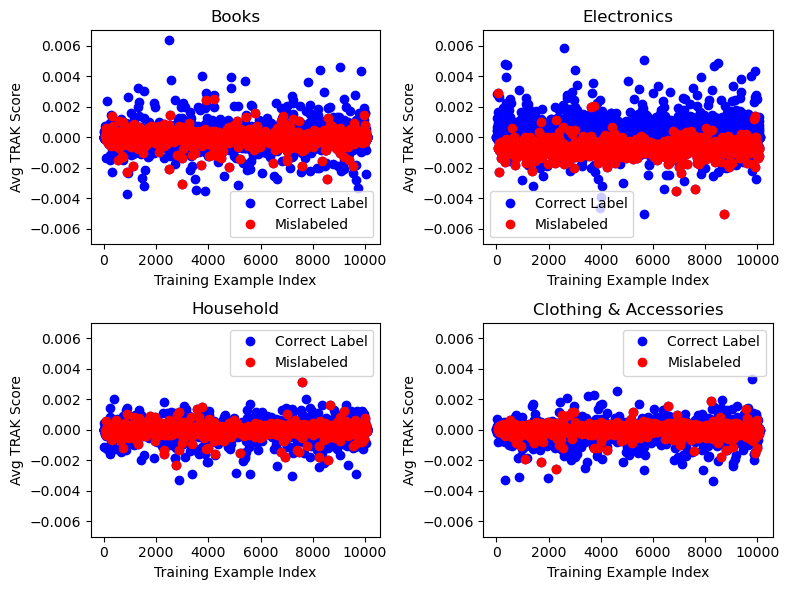

In [14]:
subplot_num = 1
f = plt.figure(figsize=(8,6))

for class_label in avg_influence_dict.keys():
    plt.subplot(2, 2, subplot_num)
    subplot_num+=1
    
    mislab_ys = [avg_influence_dict[class_label][i] for i in mislab_idxs]
    plt.plot([x for x in range(len(avg_influence_dict[class_label]))], avg_influence_dict[class_label], "o", c="blue", zorder=1, label="Correct Label")
    plt.plot(mislab_idxs, mislab_ys, "o", c="red", zorder=2, label="Mislabeled")
    
    plt.ylim(-0.007, 0.007)
    plt.title(label_convert_dict[class_label])
    plt.ylabel("Avg TRAK Score")
    plt.xlabel("Training Example Index")
    plt.legend()
    
plt.tight_layout()
plt.show()

### Average Validation TRAK Score Overall for Every Training Example Plot

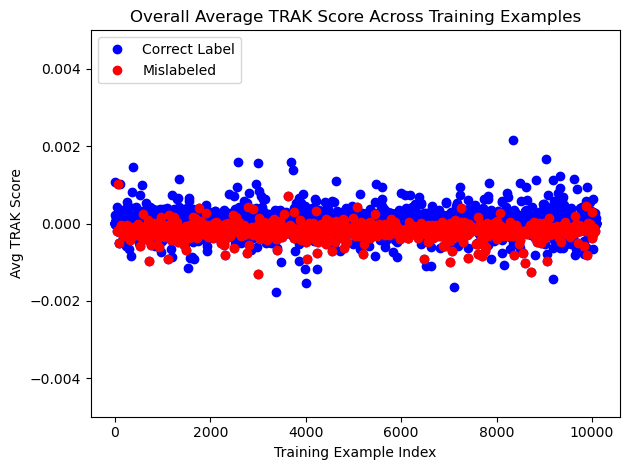

In [17]:
avg_overall_score = np.mean(list(avg_influence_dict.values()), axis=0)
avg_mislab_ys = [stdev_overall_score[i] for i in mislab_idxs]
plt.plot(x_axis, avg_overall_score, "o", c="blue", zorder=1, label="Correct Label")
plt.plot(mislab_idxs, avg_mislab_ys, "o", c="red", zorder=2, label="Mislabeled")

plt.title("Overall Average TRAK Score Across Training Examples")
plt.ylim(-0.005, 0.005)
plt.ylabel("Avg TRAK Score")
plt.xlabel("Training Example Index")
plt.legend()
plt.tight_layout()
plt.show()

### Overall StDev Validation TRAK Score for Every Training Example Plot

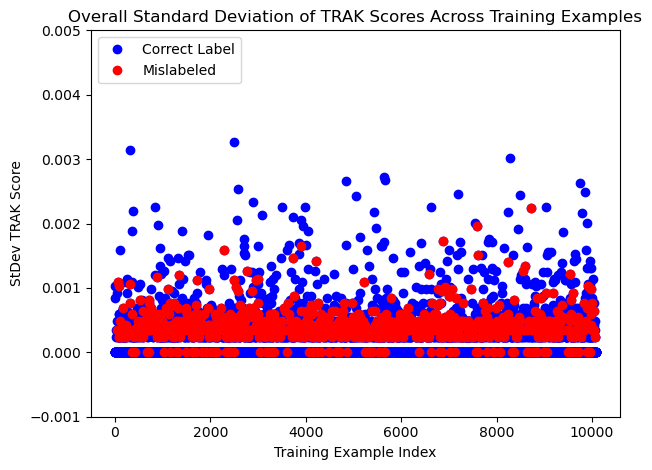

In [23]:
stdev_overall_score = np.std(list(avg_influence_dict.values()), axis=0)
stdev_mislab_ys = [stdev_overall_score[i] for i in mislab_idxs]
plt.plot(x_axis, stdev_overall_score, "o", c="blue", zorder=1, label="Correct Label")
plt.plot(mislab_idxs, stdev_mislab_ys, "o", c="red", zorder=2, label="Mislabeled")

plt.title("Overall Standard Deviation of TRAK Scores Across Training Examples")
plt.ylim(-0.001, 0.005)
plt.ylabel("StDev TRAK Score")
plt.xlabel("Training Example Index")
plt.legend()
plt.tight_layout()
plt.show()

### Median Validation TRAK Score by Category for Every Training Example Plot

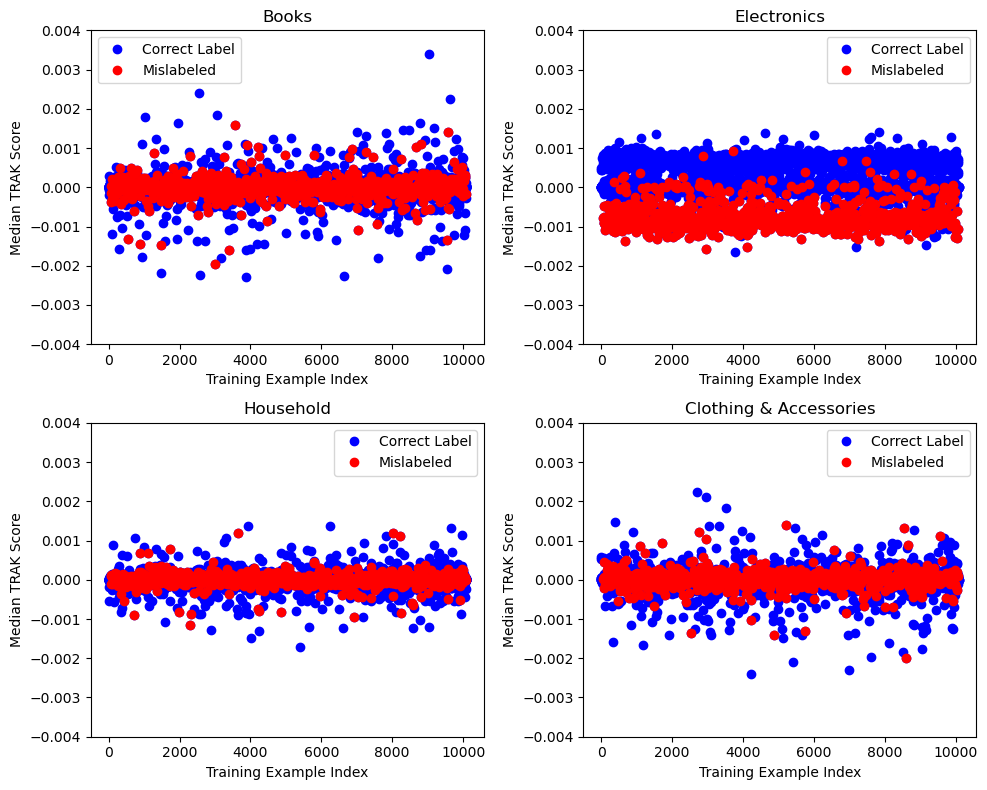

In [30]:
subplot_num = 1
f = plt.figure(figsize=(10,8))

for key in score_dict:
    plt.subplot(2, 2, subplot_num)
    subplot_num+=1
    
    median = np.median(score_dict[key], axis=0)
    median_mislab_ys = [median[i] for i in mislab_idxs]
    plt.plot(x_axis, median, "o", c="blue", zorder=1, label="Correct Label")
    plt.plot(mislab_idxs, median_mislab_ys, "o", c="red", zorder=2, label="Mislabeled")
    
    plt.title(label_convert_dict[key])
    plt.ylim(-0.004, 0.004)
    plt.ylabel("Median TRAK Score")
    plt.xlabel("Training Example Index")
    plt.legend()

plt.tight_layout()
plt.show()
    

### Violin Plot of Median TRAK Score by Category

1 Books
3 Electronics
0 Household
2 Clothing & Accessories


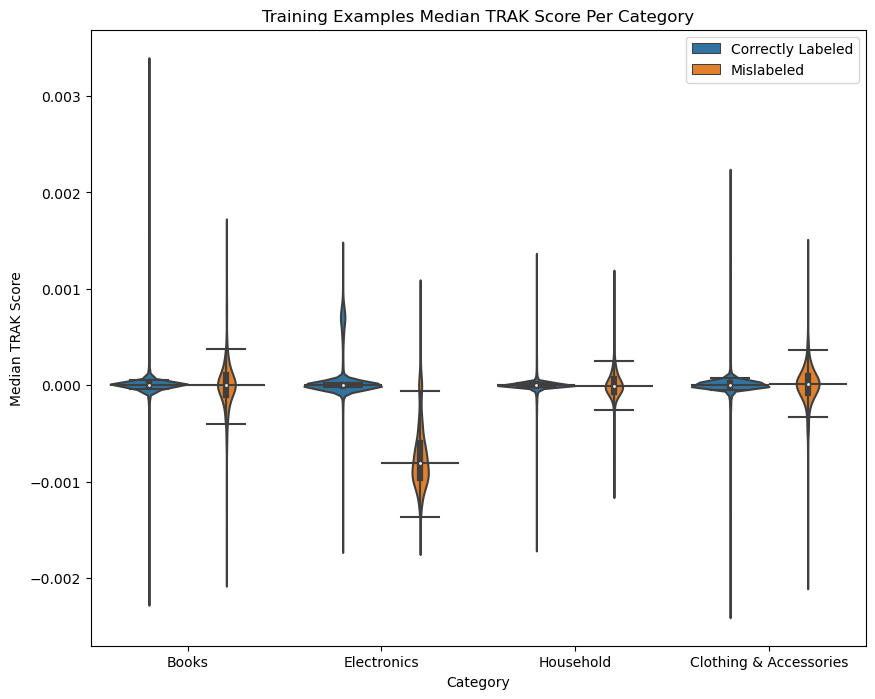

In [31]:
df_list = []
for key in score_dict:
    df = pd.DataFrame()
    print(key, label_convert_dict[key])
    df["median"] = np.median(score_dict[key], axis=0)
    df["class"] = [label_convert_dict[key]]*len(df["median"])
    df["is_mislab"] = ["Mislabeled" if i in mislab_idxs else "Correctly Labeled" for i in range(len(df["median"]))]
    df_list.append(df)

full_df = pd.concat(df_list, axis=0)

fig, ax = plt.subplots(figsize=(10, 8))
#plt.figure(figsize=(10, 8))
sns.boxplot(x="class", y="median", hue="is_mislab", data=full_df, showbox=False, showfliers=False)
sns.violinplot(x="class", y="median", hue="is_mislab", data=full_df)
handles, labels = ax.get_legend_handles_labels()
plt.legend(handles[0:2], labels[0:2],title="")
plt.xlabel("Category")
plt.ylabel("Median TRAK Score")
plt.title("Training Examples Median TRAK Score Per Category")
plt.show()

### ROC Curve

In [64]:
from sklearn.metrics import roc_curve, auc

In [33]:
train_df.head()

,class,text,class_int,mislabeled_labels
35916,Clothing & Accessories,Campus Sutra Men's Checkered Casual Shirts Wea...,2,2
28851,Books,Modern Death: How Medicine Changed the End of ...,1,1
34948,Clothing & Accessories,Larwa Men's Ceremony Kurta Pyjama Set with But...,2,2
24279,Books,Medical Astrology for Healing About the Author...,1,1
36164,Clothing & Accessories,ZUZUU Beautiful Women's Imported Crystal Stret...,2,2


In [109]:
mislabeled_class_int = 3
y_true_mislab = [int(x) for x in list(train_df["class_int"] != train_df["mislabeled_labels"])] # 0 if example not mislabeled, 1 if example is mislabeled
median = np.median(score_dict[mislabeled_class_int], axis=0)

false_pos, true_pos, thresh = roc_curve(y_true_mislab, median*(-1)) # Invert median score since roc_curve is only calculated above threshold, not below
thresh = thresh * (-1) # Undo invert after roc calculation

auc_val = auc(false_pos, true_pos)
gmeans = np.sqrt(true_pos * (1-false_pos))

# locate the index of the largest g-mean
best_ix = np.argmax(gmeans)
print('Best Threshold=%f, G-Mean=%.3f' % (thresh[best_ix], gmeans[best_ix]))

Best Threshold=-0.000078, G-Mean=0.943


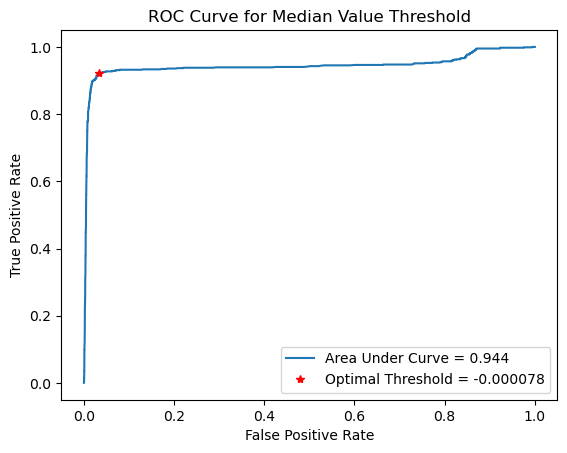

In [108]:
plt.plot(false_pos, true_pos, label= f"Area Under Curve = {auc_val:.3f}")
plt.plot(false_pos[best_ix], true_pos[best_ix], "*", color="red", label= f"Optimal Threshold = {thresh[best_ix]:.6f}")
plt.title("ROC Curve for Median Value Threshold")
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.show()